# ML4CV Assignement

This paper summarize all the work made for 

In [3]:
!gdown https://drive.google.com/drive/folders/11UBNiSbg1dvmvUCTnScMf0bb1P5QHnrl?usp=sharing --folder

!gdown https://drive.google.com/drive/folders/16UjFV-zWcWO2mJPSbTBR4K0talyauq1d?usp=sharing --folder

!pip install fvcore

Retrieving folder contents
Processing file 1MnUQsiB_33qmSl9J4MKwM93KU15J_xoR r34_NBt1D.pth
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1MnUQsiB_33qmSl9J4MKwM93KU15J_xoR
To: /kaggle/working/pretrained_weight/r34_NBt1D.pth
100%|██████████████████████████████████████| 61.3M/61.3M [00:00<00:00, 64.5MB/s]
Download completed
Retrieving folder contents
Processing file 1z1wGQQEtJJWTlaxNjPetS0TH4m73TWE9 build_model.py
Processing file 1BO2xUrZM6p9smLaxc8CiZO13Cbkz0XFA context_modules.py
Processing file 1zJEHbspXwy4gjPsrpH6581dRdQKwLnKB model_one_modality.py
Processing file 1WoIuvTK3qeIW_yBqC7oZc8hvNUCPnyIG model_utils.py
Processing file 1bOK4momkV_32rqZnal3rbIQtcIYM93MD model.py
Processing file 1DHx1bHqIFqCN6rTt31849voMjCsIxlUA resnet.py
Processing file 1vKB2ZaCCnCXzvtWTapmn4j7G-JmQZ4Od rgb_depth_fusion.py
Retrieving folder contents completed
Building directory structure
Building dire

In [4]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.init as init
import torchvision
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from typing import Optional, Callable, Union, Tuple, Dict, List
from torch import Tensor
from torchvision import transforms
from torchvision.transforms import v2
from models.build_model import build_model
import json
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm import tqdm
from PIL import Image
import random
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR
from fvcore.nn import FlopCountAnalysis, parameter_count
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
DATA_DIR = "./data"
known_classes = 13

#path to streethazards dataset
train_odgt_file = f"{DATA_DIR}/streethazards_train/train.odgt"
val_odgt_file = f"{DATA_DIR}/streethazards_train/validation.odgt"
test_odgt_file = f"{DATA_DIR}/streethazards_test/test.odgt"

height = 512
width = 896


"""
Source: https://github.com/hendrycks/anomaly-seg/issues/15#issuecomment-890300278
"""
COLORS = np.array([
[  0,   0,   0], # // unlabeled     =   0, black
[ 70,  70,  70], # // building      =   1, gray
[190, 153, 153], # // fence         =   2, pinkish
[250, 170, 160], # // other         =   3, pink
[220,  20,  60], # // pedestrian    =   4, 
[153, 153, 153], # // pole          =   5,
[157, 234,  50], # // road line     =   6, 
[128,  64, 128], # // road          =   7,
[244,  35, 232], # // sidewalk      =   8,
[107, 142,  35], # // vegetation    =   9, 
[  0,   0, 142], # // car           =  10,
[102, 102, 156], # // wall          =  11, 
[220, 220,   0], # // traffic sign  =  12,
[ 60, 250, 240], # // anomaly       =  13,
]) 

In [6]:
!mkdir -p $DATA_DIR
!test ! -d $DATA_DIR/train \
    && wget -O $DATA_DIR/train.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar \
    && tar -xf $DATA_DIR/train.tar -C $DATA_DIR \
    && rm -r $DATA_DIR/train.tar \
    && mv $DATA_DIR/train $DATA_DIR/streethazards_train
!test ! -d $DATA_DIR/test \
    && wget -O $DATA_DIR/test.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar \
    && tar -xf $DATA_DIR/test.tar -C $DATA_DIR \
    && rm -r $DATA_DIR/test.tar\
    && mv $DATA_DIR/test $DATA_DIR/streethazards_test

--2025-11-10 14:10:58--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9386226176 (8.7G) [application/x-tar]
Saving to: ‘./data/train.tar’

./data/train.tar    100%[===================>]   8.74G   145MB/s    in 78s     

2025-11-10 14:12:16 (115 MB/s) - ‘./data/train.tar’ saved [9386226176/9386226176]

--2025-11-10 14:12:41--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2150484992 (2.0G) [application/x-tar]
Saving to: ‘./data/test.tar’

./data/test.tar     100%[===================

In [7]:
class AUPR:
    """
    Compute the mean Average Precision (AUPR) for binary anomaly detection tasks.

    Attributes:
        anomaly_idx (int): The class index considered as anomaly.
        mean_aupr (List[float]): Stores AUPR values per sample for averaging.
    """
    
    def __init__(self, anomaly_idx: int = 13):
        
        self.mean_aupr = []
        self.anomaly_idx = anomaly_idx

    def update(self, anomaly_score: torch.Tensor, labels: torch.Tensor) -> None:
        """
        Update the internal AUPR list with new batch of predictions and labels.
        """
    
        for i in range(anomaly_score.shape[0]):
            
            preds, lbl = anomaly_score[i], (labels[i] == self.anomaly_idx)
            
            if preds.dim() == 2: preds = preds.unsqueeze(0)
            if lbl.dim() == 2: lbl = lbl.unsqueeze(0)
            preds, lbl = preds.cpu(), lbl.cpu()
            self.mean_aupr.append(average_precision_score(lbl.type(torch.int32).flatten().numpy(),preds.type(torch.float32).flatten().numpy()))
            
    def get_results(self) -> float:
        """
        Get the mean AUPR score across all processed batches.

        Returns:
            float: Mean AUPR value.
        """
        
        return sum(self.mean_aupr)/len(self.mean_aupr)

In [22]:
class MeanIoU:
    """
    Computes the mean Intersection over Union for multi-class semantic segmentation.

    Based on implementation from:
    https://github.com/Jun-CEN/Open-World-Semantic-Segmentation

    Attributes:
        n_classes (int): Number of classes in the segmentation task.
        confusion_matrix (np.ndarray): Running total confusion matrix.
    """
    
    def __init__(self, n_classes: int = len(COLORS)-1):
        """
        Initialize the MeanIoU evaluator.

        Args:
            n_classes (int): Number of segmentation classes. Defaults to `StreetHazardsClasses.ANOMALY`.
        """
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))
        
    def update(self, label_trues: torch.Tensor, logits: torch.Tensor, segmentated = False, prediction_on_cpu = False) -> None:
        """
        Update the internal confusion matrix using predicted and ground truth labels.

        Args:
            label_trues (torch.Tensor): Ground truth labels of shape (B, H, W).
            logits (torch.Tensor): Model output logits of shape (B, C, H, W).
        """
        
        if not segmentated:
            label_preds = torch.argmax(logits, dim=1)
        else :
            label_preds = logits
        if not prediction_on_cpu:
            label_preds, label_trues = label_preds.cpu().numpy(), label_trues.cpu().numpy()
        else :
            label_trues = label_trues.cpu().numpy()
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist( lt.flatten(), lp.flatten())

    def _fast_hist(self, label_true, label_pred):
        mask = (label_true >= 0) & (label_true < self.n_classes)
        hist = np.bincount(
            self.n_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.n_classes ** 2,
        ).reshape(self.n_classes, self.n_classes)
        return hist

    def get_results(self) -> Dict:
        """
        Compute evaluation metrics from the accumulated confusion matrix.

        Returns:
            Dict[str, Any]: A dictionary containing:
                - "Mean IoU" (float): Mean intersection over union across all classes.
                - "Class IoU" (dict): Per-class IoU scores.
        """
        hist = self.confusion_matrix

        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu, axis= 0)
        cls_iu = dict(zip(range(self.n_classes), iu))

        return {
                "Mean IoU": mean_iu,
                "Class IoU": cls_iu,
            }

In [8]:
def visualize_annotation(annotation_img: np.ndarray | torch.Tensor, ax=None, title= None) -> None:
    """
    Visualize a segmentation annotation using a predefined color palette.

    Args:
        annotation_img (np.ndarray | torch.Tensor): 2D array with class indices.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, uses current axis.
    """
    if ax is None: ax = plt.gca()
    annotation_img = np.asarray(annotation_img)
    img_new = np.zeros((*annotation_img.shape, 3))

    for index, color in enumerate(COLORS):
        img_new[annotation_img == index] = color

    ax.imshow(img_new / 255.0)
    if title:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

def visualize_scene(image: np.ndarray | torch.Tensor, ax=None, title= None,sub_title= None) -> None:
    """
    Visualize a raw RGB scene image.

    Args:
        image (np.ndarray | torch.Tensor): Image tensor or array in [C, H, W] or [H, W, C] format.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, uses current axis.
    """
    if ax is None: ax = plt.gca()
    image = np.asarray(image)
    if len(image.shape) == 2:
        ax.imshow(image)
    else:
        ax.imshow(np.moveaxis(image, 0, -1))
    if title:
        ax.set_title(title)
    if sub_title:
        ax.figtext(0.5, 0.01, sub_title, wrap=True, horizontalalignment='center', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

In [9]:
def compute_mean_std_channels(dataset: torch.utils.data.Dataset) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Computes the per-channel mean and standard deviation across all images in a dataset.

    This function is used when you want to normalize your dataset with statistics computed from your own data rather than relying on precomputed values like ImageNet mean/std.

    Args:
        dataset (torch.utils.data.Dataset): A dataset from which compute the mean and standard deviation.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: 
            - mean: A tensor of shape (C,) containing the average value for each channel.
            - std: A tensor of shape (C,) containing the standard deviation for each channel.
    """
    
    data_loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    nb_samples = 0

    for batch in tqdm(data_loader):
        images = batch["image"]
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1) 
    
        mean += images.mean(2).sum(0)  
        std += images.std(2).sum(0)
        nb_samples += batch_samples 
        del batch

    mean /= nb_samples
    std /= nb_samples
    return mean, std

def compute_class_frequency(
    dataset: None,
    num_classes: int,
    normalize: bool = False,
    ax = None,
    caption: str = '',
) -> torch.Tensor:
    
    """
    Compute the frequency of pixels per class, given a dataset

    Args:
        dataset (Dataset): A PyTorch dataset object that yields samples with a 'labels' key.
        num_classes (int): The number of unique classes in the dataset.
        normalize (bool, optional): Whether to normalize the computed weights to sum to the number of classes.
        ax (matplotlib.axes.Axes, optional): Matplotlib Axes object to draw the frequency plot on (required if plot_frequencies is True).
        caption (str): title to use for the plot

    Returns:
        torch.Tensor: A tensor of shape (num_classes,) containing the inverse frequency weights for each class.
    """
    
    data_loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)
    pixels_per_class = torch.zeros(num_classes, dtype=torch.float32)

    for batch in tqdm(data_loader):
        labels = batch['labels'] 
        labels = labels.view(-1) 
        counts = torch.bincount(labels, minlength=num_classes)
        pixels_per_class += counts

    total_pixels = pixels_per_class.sum()

    return pixels_per_class




In [10]:
class StreetHazardsDataset(Dataset):
    """
    A custom PyTorch Dataset for the StreetHazards inliner dataset.

    This dataset reads image and segmentation label paths from a `.odgt` file,
    applies optional resizing and spatial transformations, and returns
    dictionary-style samples with normalized image tensors and label tensors.

    Args:
        odgt_file (str): Path to the `.odgt` file containing image and label metadata.
        image_resize (Tuple[int, int], optional): Target size to resize images and labels. 
        spatial_transforms (Callable, optional): Optional transformation function applied to both images and labels.
        mean_std (Tuple[List[float], List[float]], optional): Mean and standard deviation for image normalization.
        
    """
    def __init__(
        self,
        odgt_file: str,
        image_resize: Tuple[int, int] = (512, 896),
        spatial_transforms: Optional[Callable] = None,
        mean_std: Tuple[List[float], List[float]] = None,
        image_only_transforms: Optional[Callable] = None,
    ):

        self.spatial_transforms = spatial_transforms
        self.mean_std = mean_std
        self.image_resize = image_resize
        self.image_only_transforms = image_only_transforms

        with open(odgt_file, "r") as f:
            odgt_data = json.load(f)
        

        self.paths = [
            {
                "image": os.path.join(Path(odgt_file).parent, data["fpath_img"]),
                "labels": os.path.join(Path(odgt_file).parent, data["fpath_segm"]),
            }
            for data in odgt_data 
        ]
    
    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:

        image = Image.open(self.paths[idx]["image"]).convert("RGB")
        labels = Image.open(self.paths[idx]["labels"])

        if self.image_resize:
            image = transforms.Resize(self.image_resize, transforms.InterpolationMode.BILINEAR)(image)
            labels = transforms.Resize(self.image_resize, transforms.InterpolationMode.NEAREST)(labels)
            
        if self.spatial_transforms:
            image, labels  = self.spatial_transforms(image, labels)         

        if self.image_only_transforms:
            image = self.image_only_transforms(image)

        labels_tensor_raw = torch.as_tensor(transforms.functional.pil_to_tensor(labels), dtype=torch.int64)

        image = transforms.ToTensor()(image)
        labels = torch.as_tensor(transforms.functional.pil_to_tensor(labels), dtype=torch.int64) - 1
        
        labels = labels.squeeze(0)
        
        if self.mean_std:
            image = transforms.Normalize(mean = self.mean_std[0], std = self.mean_std[1])(image)
        

        return {'image' : image, 'labels' : labels}

class MixDataset(Dataset):
    """
    A custom PyTorch Dataset that combines an inlier (without anomalies) dataset with an outlier dataset 
    to synthetically generate training samples for anomaly detection tasks.
    Args:
        inlier_dataset (Dataset): Dataset containing normal images and segmentation labels.
        outlier_dataset (Dataset): Dataset containing anomalous images and segmentation labels.
        mean_std (Tuple, optional): Mean and std to apply to the image.
        anomaly_probability (float): Probability [0, 1] of injecting an anomaly into a given sample.
        max_anomalies (int): Maximum number of anomalies to inject per image.
        anomaly_idx (int): The label index used to represent injected anomalies in the segmentation map.
    """
    
    def __init__(
        self,
        inlier_dataset: Dataset,
        outlier_dataset: Dataset,
        mean_std: Tuple[List, List] = None,
        anomaly_probability: float = 1.0,
        max_anomalies: int = 4,
        anomaly_idx: int = 13):
        
        self.inlier_dataset = inlier_dataset
        self.outlier_dataset = outlier_dataset
        self.anomaly_idx = anomaly_idx
        self.anomaly_probability = anomaly_probability
        self.max_anomalies = max_anomalies
        self.mean_std = mean_std
    
    def __len__(self) -> int:
        return len(self.inlier_dataset)
        
    def inject_anomalies(self, image: Tensor, label: Tensor) -> tuple[Tensor, Tensor]:
        """
        Injects up to max_anomalies random anomalous patches into the image and label.

        Returns:
            image (Tensor): Modified image with anomalies.
            label (Tensor): Corresponding label with injected anomaly class index.
        """

        n_anomalies = random.randint(1, self.max_anomalies)
        for i in range(n_anomalies):

            rand_idx = random.randint(0, len(self.outlier_dataset)-1)

            anomaly_size = (np.random.randint(image.shape[1]*0.1, image.shape[1]*0.3), np.random.randint(image.shape[2]*0.1, image.shape[2]*0.3))
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=anomaly_size)
            possible_classes = []
            while len(possible_classes) == 0: # In some cases there are no classes available
                anomaly_idx = np.random.randint(0, len(self.outlier_dataset))
                anomaly_image = transforms.ToTensor()(self.outlier_dataset[anomaly_idx][0])
                anomaly_annot = torch.from_numpy(np.array(self.outlier_dataset[anomaly_idx][1])).unsqueeze(0)
                possible_classes = np.unique(anomaly_annot)[1:-1]

            anomaly_class = np.random.choice(possible_classes)
            anomaly_image = F.interpolate(anomaly_image.unsqueeze(0), size=(h, w), mode="bilinear").squeeze(0)
            anomaly_annot = F.interpolate(anomaly_annot.unsqueeze(0), size=(h, w), mode="nearest").squeeze((0, 1))

            # Insert anomaly
            image[:, i:i+h, j:j+w][:, anomaly_annot == anomaly_class] = anomaly_image[:, anomaly_annot == anomaly_class]
            label[i:i+h, j:j+w][anomaly_annot == anomaly_class] = self.anomaly_idx

        return image, label

    def __getitem__(self, idx: int) -> dict:

        image, label = self.inlier_dataset[idx].values()
        label_original = torch.clone(label)
        p = random.random()
        if p < self.anomaly_probability:
            image, label = self.inject_anomalies(image, label)
            w, h = label.shape[0], label.shape[1]

        if self.mean_std:
            image = transforms.Normalize(mean = self.mean_std[0], std = self.mean_std[1])(image)
            
        return {"image" : image,"labels_anomaly": label,"labels_original": label_original}

In [11]:
class SD_loss(nn.Module):
    def __init__(self, device: torch.device,inverse_class_weights,num_classes,cross_weight,feat_weight):
        super().__init__()
        self.device = device
        self.inverse_class_weights = inverse_class_weights
        self.num_classes = num_classes
        self.cross_weight = cross_weight
        self.feat_weight = feat_weight
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=inverse_class_weights, ignore_index=-1)
    
    def forward(self,logits,targets,previous_means=None,previous_variances=None):

        C_loss = elf.cross_entropy_loss(logits, targets)

        if previous_means is None or previous_variances is None:
            return l_sem

        total_feat_loss = 0.0
        logits_permuted = logits.permute(0, 2, 3, 1)
        
        for c in range(self.num_classes):
            class_mask = (targets == c)
            if class_mask.sum() == 0:
                continue

            features = logits_permuted[class_mask]
            c_mean = previous_means[c]
            c_variance = previous_variances[c]
            c_std = torch.sqrt(c_variance) + 1e-6

            standardized_diff = (features - c_mean) / c_std
            total_feat_loss += torch.pow(standardized_diff, 2).sum()
        
        l_feat = total_feat_loss / (targets.numel()) # Normalizza per tutti i pixel

        return self.cross_weight * l_sem + self.feat_weight * l_feat

In [12]:
class CD_loss(nn.Module):
    def __init__(self, device: torch.device,num_classes,obje_weight,contrastive_weight,threshold,temperature):
        super().__init__()
        self.device = device
        self.num_classes = num_classes
        self.obje_weight = obje_weight
        self.contrastive_weight = contrastive_weight
        self.threshold = threshold
        self.temperature = temperature

    def forward(self, logits, binary_targets, semantic_targets, previous_means=None):
        # 1. Calcolo Lobj
        squared_norms = torch.sum(logits.pow(2), dim=1)
        loss_known = torch.relu(self.threshold - squared_norms)
        loss_unknown = squared_norms
        targets_float = binary_targets.float()
        per_pixel_loss = loss_known * (1 - targets_float) + loss_unknown * targets_float
        total_obj_loss = per_pixel_loss.sum()

        if previous_means is None:
            return self.obje_weight * total_obj_loss

        # 2. Calcolo Lcont
        # Calcola le medie del batch corrente per la loss contrastiva
        current_batch_means = self.calculate_means_multiclass(logits, semantic_targets)
        
        similarities = torch.matmul(current_batch_means, previous_means.T) / self.temperature
        contrastive_targets = torch.arange(self.num_classes, device=self.device)
        l_cont = F.cross_entropy(similarities, contrastive_targets, reduction="sum")
        
        total_loss = self.obje_weight * total_obj_loss + self.contrastive_weight * l_cont
        return total_loss

    def calculate_means_multiclass(self, logits, semantic_targets):
        feature_sum = torch.zeros(self.num_classes, self.feature_dim, dtype=torch.float, device=self.device)
        counts = torch.zeros(self.num_classes, dtype=torch.float, device=self.device)
        logits_permuted = logits.permute(0, 2, 3, 1)
        for c in range(self.num_classes):
            class_mask = (semantic_targets == c)
            count = class_mask.sum()
            if count > 0:
                counts[c] = count
                features = logits_permuted[class_mask]
                feature_sum[c] = features.sum(dim=0)
        denominator = counts.unsqueeze(1)
        means = torch.nan_to_num(feature_sum / denominator)
        return means

In [13]:
class OpenSetSegmentation(nn.Module):

    def __init__(self,
                 model,
                 Constrastive_Decoder_loss,
                 Semantic_Decoder_loss,
                 device,
                 metrics,
                 scheduler_class = None,
                 dataset_name = "StreetHazards",
                 num_known_classes = 13,
                 lr = 1e-3,
                 weight_decay = 1e-4,
                 optimizer_class = torch.optim.Adam,):

        super().__init__()
        self.dataset = dataset_name
        self.Constrastive_Decoder_loss = Constrastive_Decoder_loss
        self.Semantic_Decoder_loss = Semantic_Decoder_loss
        self.device = device
        self.model = model.to(self.device)
        self.num_known_classes = num_known_classes
        self.metrics = metrics
        self.feature_dim = self.num_known_classes

        self.optimizer = optimizer_class(self.model.parameters(),lr,weight_decay = weight_decay)
        self.scheduler_class = scheduler_class
        
        self.LoadDataset()


    

    def LoadDataset(self,COMPUTE_MEAN_STD=True):
        if self.dataset == "StreetHazards":
            shape_resize = (512, 896)


            if COMPUTE_MEAN_STD:
                mean_std = compute_mean_std_channels(StreetHazardsDataset(odgt_file= train_odgt_file,
                                                                                                       image_resize = shape_resize,
                                                                                                       spatial_transforms=None,
                                                                                                       mean_std=None))
            else:
                mean_std = [0.3302, 0.3459, 0.373], [0.1595, 0.1577, 0.1712]



            image_augmentations = transforms.Compose([
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
            ])
            
            
            
            spatial_transforms = transforms.v2.Compose([
                transforms.v2.RandomHorizontalFlip(),
            ])
            
            train_dataset = StreetHazardsDataset(
                odgt_file= train_odgt_file,
                image_resize = shape_resize,
                spatial_transforms=spatial_transforms,
                image_only_transforms=image_augmentations,
                mean_std=mean_std
            )
            
            val_dataset = StreetHazardsDataset(
                odgt_file= val_odgt_file,
                image_resize = shape_resize,
                spatial_transforms=None,
                mean_std=mean_std
            )
            
            test_dataset = StreetHazardsDataset(
                odgt_file= test_odgt_file,
                image_resize = shape_resize,
                spatial_transforms=None,
                mean_std=mean_std
            )
            
            self.train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4,drop_last= True,pin_memory=True)
            self.val_dl = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4,drop_last= True,pin_memory=True)
            self.test_dl = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4,drop_last= True,pin_memory=True)

            dataset_train = torchvision.datasets.SBDataset(DATA_DIR, image_set='train', mode ='segmentation',download= False)
            dataset_val = torchvision.datasets.SBDataset(DATA_DIR, image_set='val', mode ='segmentation',download= False)

            mix_train = MixDataset(inlier_dataset= StreetHazardsDataset(odgt_file= train_odgt_file,
                                                                        image_resize = (512, 896),
                                                                        spatial_transforms=None,
                                                                        mean_std=None), 
                                outlier_dataset= dataset_train, 
                                mean_std= mean_std)

            mix_val = MixDataset(inlier_dataset= StreetHazardsDataset(odgt_file= val_odgt_file,
                                                                    image_resize = (512, 896),
                                                                    spatial_transforms=None,
                                                                    mean_std=None), 
                                outlier_dataset= dataset_val, 
                                mean_std= mean_std)

            self.mix_train_dl = DataLoader(mix_train, batch_size=8, shuffle=True, num_workers=2)
            self.mix_val_dl = DataLoader(mix_val, batch_size=8, shuffle=False, num_workers=2)


    def train(self,num_epochs,path_preTrained = None) -> None:

        if self.scheduler_class is not None: 
            self.scheduler = self.scheduler_class(self.optimizer, T_max=num_epochs)

        if path_preTrained is not None:
            self.loadModel(path_preTrained)

        PATIENCE = 100  

        best_val_loss = float('inf')
        patience_counter = 0

        self.model.train()
        
        train_losses = []
        val_losses = []

        for epoch in tqdm(range(num_epochs), desc="Epoch"):    
            self.model.train()

            losses = []
            
            for batch in self.mix_train_dl: 

                imgs = batch['image'].to(self.device)
                labels_original = batch['labels_original'].to(self.device)
                labels_anomaly = batch['labels_anomaly'].to(self.device)

                labels_binary = (labels_anomaly == 13).long()   

               
                logits_semantic, logits_discriminative = self.model(imgs)

                loss_semantic = self.Semantic_Decoder_loss(logits_semantic, labels_original, self.model.means_S, self.model.variances_S)
                loss_contrastive = self.Constrastive_Decoder_loss(logits_discriminative, labels_binary, labels_original, self.model.means_C)

                total_loss = loss_contrastive + loss_semantic

                losses.append(total_loss.item())
                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()
            
                del total_loss
            
            self.update_epoch_stats()

            if self.scheduler_class is not None:    
                self.scheduler.step()

            l = sum(losses) / len(losses)

            train_losses.append(l)

            eval_l = self.eval(epoch)

            val_losses.append(eval_l)

            
            if eval_l < best_val_loss:
                # Miglioramento! Salva il modello e resetta la pazienza.
                print(f"  -> Val loss migliorata ({best_val_loss:.4f} --> {eval_l:.4f}). Salvo il modello.")
                best_val_loss = eval_l
                torch.save(self.model.state_dict(), f"50OSS_weights_best.pth")
                patience_counter = 0
            else:
                # Nessun miglioramento. Aumenta il contatore.
                patience_counter += 1
                print(f"  -> Val loss non migliorata. Pazienza: {patience_counter}/{PATIENCE}")
        
            # Controlla se la pazienza è esaurita
            if patience_counter >= PATIENCE:
                print("Early stopping: la pazienza è esaurita. Fermo il training.")
                break # Esce dal loop for delle epoche
            

            print(f"Epoch {epoch + 1} Loss {l}", end = ' ')
        np.save(f"OSS_train_loss.npy",np.array(train_losses))
        np.save(f"OSS_val_loss.npy",np.array(val_losses))
        torch.save(self.model.state_dict(), f"50OSS_weights_{num_epochs}.pth")
        

    @torch.no_grad()
    def update_epoch_stats(self):
        print("\nUpdating epoch statistics for both decoders")
        self.model.eval()
        
        # --- Accumulatori per il Decoder SEMANTICO (basato su True Positives) ---
        sum_s = torch.zeros_like(self.model.means_S)
        counts_s = torch.zeros(self.num_known_classes, device=self.device)
        
        # --- Accumulatori per il Decoder CONTRASTIVO (basato su Ground Truth) ---
        sum_c = torch.zeros_like(self.model.means_C)
        counts_c = torch.zeros(self.num_known_classes, device=self.device)

        # --- 1. Primo Passaggio: Calcolo somme per le medie ---
        for batch in tqdm(self.mix_train_dl, desc="Updating Means"):
            logits_s, logits_c = self.model(batch['image'].to(self.device))
            semantic_targets = batch['labels_original'].to(self.device)
            
            # Predizioni del decoder semantico per trovare i True Positives
            preds_s = torch.argmax(logits_s, dim=1)
            correct_mask = (preds_s == semantic_targets)

            permuted_s = logits_s.permute(0, 2, 3, 1)
            permuted_c = logits_c.permute(0, 2, 3, 1)

            for c in range(self.num_known_classes):
                # --- Logica per il Decoder Semantico (True Positives) ---
                true_positive_mask = correct_mask & (semantic_targets == c)
                count_tp = true_positive_mask.sum()
                if count_tp > 0:
                    counts_s[c] += count_tp
                    sum_s[c] += permuted_s[true_positive_mask].sum(dim=0)

                # --- Logica per il Decoder Contrastivo (Ground Truth) ---
                ground_truth_mask = (semantic_targets == c)
                count_gt = ground_truth_mask.sum()
                if count_gt > 0:
                    counts_c[c] += count_gt
                    # NOTA: le medie del contrastive decoder si calcolano sui suoi logit
                    sum_c[c] += permuted_c[ground_truth_mask].sum(dim=0)
        
        # Calcola e aggiorna le medie finali SEPARATAMENTE con i loro conteggi
        denominator_s = counts_s.unsqueeze(1).clamp(min=1)
        self.model.means_S = torch.nan_to_num(sum_s / denominator_s)
        
        denominator_c = counts_c.unsqueeze(1).clamp(min=1)
        self.model.means_C = torch.nan_to_num(sum_c / denominator_c)
        
        # --- 2. Secondo Passaggio: Calcolo varianza per il decoder SEMANTICO ---
        # La varianza si calcola sempre sullo stesso set di pixel della media (True Positives)
        sum_sq_s = torch.zeros_like(self.model.variances_S)
        for batch in tqdm(self.mix_train_dl, desc="Updating Variance"):
            logits_s, _ = self.model(batch['image'].to(self.device))
            semantic_targets = batch['labels_original'].to(self.device)
            preds_s = torch.argmax(logits_s, dim=1)
            correct_mask = (preds_s == semantic_targets)
            permuted_s = logits_s.permute(0, 2, 3, 1)

            for c in range(self.num_known_classes):
                true_positive_mask = correct_mask & (semantic_targets == c)
                if true_positive_mask.sum() > 0:
                    # Usa la media SEMANTICA appena calcolata
                    diff = permuted_s[true_positive_mask] - self.model.means_S[c]
                    sum_sq_s[c] += torch.pow(diff, 2).sum(dim=0)

        # Usa il denominatore corretto per la varianza (counts_s)
        self.model.variances_S = torch.nan_to_num(sum_sq_s / denominator_s)
        print("Statistics updated correctly.")


    @torch.no_grad()
    def eval(self,epoch) -> None:
        
        self.model.eval()
        
        losses = []
        results = []
        
        for batch in self.mix_val_dl:
    
            imgs = batch['image'].to(self.device)
            labels_original = batch['labels_original'].to(self.device)
            labels_anomaly = batch['labels_anomaly'].to(self.device)

            labels_binary = torch.clone(labels_anomaly)
            labels_binary[labels_binary != 13] = 0
            labels_binary[labels_binary == 13] = 1

            logits_semantic, logits_discriminative = self.model(imgs)

            loss_semantic = self.Semantic_Decoder_loss(logits_semantic, labels_original, self.model.means_S, self.model.variances_S)
            loss_contrastive = self.Constrastive_Decoder_loss(logits_discriminative, labels_binary, labels_original, self.model.means_C)

            total_loss = loss_contrastive + loss_semantic
                        
            losses.append(total_loss.item())

            for metric in self.metrics:
                metric.update(labels_original, logits_semantic)
                
                
        for metric in self.metrics:
            results.append(metric.get_results())
        
        l = sum(losses) / len(losses)
        
        print(f"| validation Metrics:")
        print(f"  Loss: {l:.4f}")
        for result in results:
            print(result)
    
        return l
    def loadModel(self,path):
        state_dict = torch.load(path, map_location=self.device)
        self.model.load_state_dict(state_dict)
        print("model loaded")
    def saveModel(self,path):
        torch.save(self.model.state_dict(), path)

    @torch.no_grad()
    def inference(self, batch):
        self.model.eval()
        imgs = batch['image'].to(self.device)
        
        # CORREZIONE: Non calcolare la loss qui! Usa i buffer salvati.
        logits_semantic, _ = self.model(imgs)
        
        B, C, H, W = logits_semantic.shape
        fp = logits_semantic.permute(0, 2, 3, 1).reshape(-1, C)
        
        # Usa i buffer del modello
        means_k = self.model.means_S.unsqueeze(0)
        variances_k = self.model.variances_S.unsqueeze(0) + 1e-6

        fp = fp.unsqueeze(1)
        diff = fp - means_k
        mahalanobis_sq = torch.sum(diff.pow(2) / variances_k, dim=2)
        fitting_scores = torch.exp(-0.5 * mahalanobis_sq)
        best_scores, best_class_indices = torch.max(fitting_scores, dim=1)
        
        score_map = best_scores.reshape(B, H, W)
        segmentation_map = best_class_indices.reshape(B, H, W)
        
        return segmentation_map, score_map

    @torch.no_grad()
    def anomaly_map(self,batch,score_map,segmentation_map,anomaly_threshold):

        unk_score_s = 1 - score_map
        
        imgs = batch['image'].to(self.device)
        _, logits_contrastive = self.model(imgs)

        squared_norms = torch.sum(logits_contrastive.pow(2), dim=1)
        unk_score_d = torch.relu(1 - squared_norms/self.Constrastive_Decoder_loss.threshold)

        unk_score_final = 0.5*(unk_score_s + unk_score_d)

        ood_label = 13 
        final_map = torch.where(unk_score_final <= anomaly_threshold, segmentation_map, torch.full_like(segmentation_map, ood_label))

        return final_map, unk_score_final

In [16]:
mean_std = ([0.3302, 0.3459, 0.373], [0.1595, 0.1577, 0.1712])

dataset_train = torchvision.datasets.SBDataset(DATA_DIR, image_set='train', mode ='segmentation',download= False)
dataset_val = torchvision.datasets.SBDataset(DATA_DIR, image_set='val', mode ='segmentation',download= False)

mix_train = MixDataset(inlier_dataset= StreetHazardsDataset(odgt_file= train_odgt_file,
                                                            image_resize = (height, width),
                                                            spatial_transforms=None,
                                                            mean_std=None), 
                       outlier_dataset= dataset_train, 
                       mean_std= mean_std)

mix_val = MixDataset(inlier_dataset= StreetHazardsDataset(odgt_file= val_odgt_file,
                                                          image_resize = (height, width),
                                                          spatial_transforms=None,
                                                          mean_std=None), 
                     outlier_dataset= dataset_val, 
                     mean_std= mean_std)

mix_train_dl = DataLoader(mix_train, batch_size=8, shuffle=True, num_workers=2)
mix_val_dl = DataLoader(mix_val, batch_size=8, shuffle=False, num_workers=2)

num_classes = 13

Net,device = build_model(height=height,
                  width=width,
                  pretrained_on_imagenet=True,
                  encoder="resnet34",
                  encoder_block="NonBottleneck1D",
                  activation="relu",
                  encoder_decoder_fusion="add",
                  n_classes = num_classes,
                  pretrained_dir="/kaggle/working/pretrained_weight")

inverse_class_weights = compute_class_frequency(StreetHazardsDataset(odgt_file= train_odgt_file,
                                                            image_resize = (512, 896),
                                                            spatial_transforms=None,
                                                            mean_std=None),num_classes=13)





Loaded r34 with encoder block NonBottleneck1D pretrained on ImageNet
/kaggle/working/pretrained_weight/r34_NBt1D.pth
Device: cuda:0






Applied He init.


100%|██████████| 641/641 [02:57<00:00,  3.61it/s]


In [17]:
OSS = OpenSetSegmentation(Net, CD_loss(device,num_classes,1,1,1,1),SD_loss(device,inverse_class_weights.to(device),num_classes,1,1),device,[])

OSS.LoadDataset()

100%|██████████| 641/641 [02:56<00:00,  3.63it/s]


In [18]:
OSS.loadModel("/kaggle/input/dualdecoder/pytorch/default/4/50OSS_weights_best.pth")

model loaded


tensor([[ 1.6282e-01, -2.6182e-02, -9.1417e-02, -6.0831e-02, -3.1540e-02,
         -6.6105e-02, -5.1175e-02,  4.0523e-02, -1.3483e-02,  2.0070e-02,
          2.2605e-04, -1.2612e-01, -7.2778e-02],
        [ 1.2698e-02,  4.2922e-02, -6.9071e-03, -1.2855e-02, -1.6502e-02,
         -3.3213e-02,  2.6954e-03,  1.6736e-02,  4.1447e-03,  1.5276e-02,
         -2.1599e-03, -3.1101e-03,  1.1879e-02],
        [ 3.4461e-03,  2.6849e-02,  6.6529e-02, -4.5796e-03, -1.7407e-02,
         -1.3925e-02,  2.5933e-03,  3.1559e-02,  3.2230e-02,  2.2356e-02,
          1.9486e-02,  1.9195e-04,  1.3572e-02],
        [-5.0678e-03,  1.3396e-02, -8.0026e-03,  4.1368e-02, -1.3175e-02,
         -2.0684e-02,  1.1298e-02,  8.5377e-03,  9.9671e-03,  6.1030e-03,
          3.2357e-04,  1.4809e-03,  8.0827e-03],
        [ 1.5403e-02,  2.7205e-02, -8.1506e-03, -9.5564e-03,  5.0241e-02,
         -2.4426e-02,  8.5264e-04, -1.0622e-02,  3.0509e-02,  2.0830e-02,
          2.1400e-02, -1.6678e-02,  1.5313e-02],
        [ 3.760

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'Mean IoU': 0.10489411655517612, 'Class IoU': {0: 0.6238685275130105, 1: 0.03626806863805269, 2: 0.00019258142845181278, 3: 0.001198886748019696, 4: 0.0, 5: 0.01852630398834048, 6: 2.4200476749391964e-05, 7: 0.48480346470754054, 8: 0.03410698666693097, 9: 0.1334747174168906, 10: 0.006321988395254179, 11: 0.017067267621118747, 12: 0.007770521616929817}}


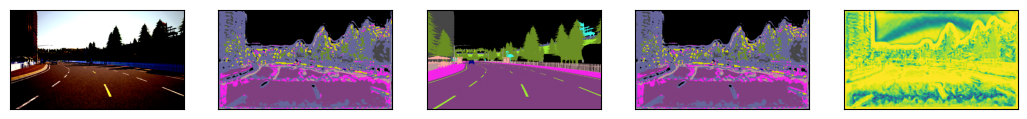

In [27]:
for batch in OSS.test_dl:

    imgs = batch['image']
    labels = batch['labels']
    
    segmentation_map, score_map = OSS.inference(batch)
    final_map, anomaly = OSS.anomaly_map(batch,score_map,segmentation_map,0.6)
    fig, axs = plt.subplots(1, 5, figsize=(13, 13))
    idx = 7
    visualize_scene(imgs[idx], axs[0])
    visualize_annotation(segmentation_map[idx].cpu().numpy(), axs[1])
    visualize_annotation(labels[idx].cpu().numpy(),axs[2])
    visualize_annotation(final_map[idx].cpu().numpy(), axs[3])
    visualize_scene(anomaly[idx].cpu().numpy(), axs[4])
    metric = MeanIoU()
    metric.update(labels,segmentation_map,segmentated = True)
    print(metric.get_results())
    break